#### Import moduldes

In [124]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

pd.set_option('display.max_columns', None)

#### Load the data provided

In [125]:
Train = pd.read_csv("../input/zindi-football/Train.csv")

In [126]:
Train.head()

,Date,Season,Match_ID,Game_ID,Home Team,Away Team,Score
0,2017-02-15,1,1.0,ID_KAG4KAE9,Antennae,Andromeda,Away win
1,2016-09-14,1,12.0,ID_T7H1XN5Z,Andromeda,Antennae,Draw
2,2016-12-12,1,13.0,ID_O1P9FGN4,Andromeda,Butterfly,Away win
3,2017-01-25,1,14.0,ID_TR5M4KQV,Andromeda,Cigar,Away win
4,2016-08-24,1,15.0,ID_EOIECRE2,Andromeda,Circinus,Home Win


In [127]:
Test = pd.read_csv("../input/zindi-football/Test.csv")

In [128]:
Test.head()

,Date,Season,Match_ID,Game_ID,Home Team,Away Team
0,2018-12-08,3,102.0,ID_8518U587,Antennae,Cosmos Redshift 7
1,2018-09-11,3,18.0,ID_H49BIKG7,Cosmos Redshift 7,Tadpole
2,2018-09-25,3,32.0,ID_PO6SP4VA,Cosmos Redshift 7,Medusa Merger
3,2018-10-02,3,40.0,ID_MZRCNBAQ,Cartwheel,Cosmos Redshift 7
4,2018-12-20,3,123.0,ID_CV9VOLIU,Cosmos Redshift 7,Needle


In [129]:
len(Test["Game_ID"].unique())

234

In [130]:
train_game_statistics = pd.read_csv("../input/foot-league/train_game_statistics.csv")
test_game_statistics = pd.read_csv("../input/foot-league/test_game_statistics.csv")
game_statistics = pd.concat([train_game_statistics, test_game_statistics])

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (20,21,25) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [131]:
game_statistics = game_statistics.drop(columns = ["Goals_scored", "Goals_conceded", "Action"])

In [132]:
game_statistics.head(5)

,Game_ID,Player_ID,id,X,Y,Team,Half,Season,Manager,Opposition_Team,Shots,SoT,Accurate passes,Inaccurate passes,Passes,Start_minutes,End_minutes,next_player,next_action,next_x,next_y,event_id,next_team,next_event_id,xt_value
0,ID_ZZKYYPVY,Player_O7HO1NOB,1.0,52.5,34.0,Circinus,1st half,2,Ryoichi,Backward,0.0,0.0,1.0,0.0,1.0,0.03,0.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ID_ZZKYYPVY,Player_O7HO1NOB,2.0,52.5,34.0,Circinus,1st half,2,Ryoichi,Backward,0.0,0.0,0.0,0.0,0.0,0.03,0.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ID_ZZKYYPVY,Player_J0V7B0YE,3.0,37.0,32.7,Circinus,1st half,2,Ryoichi,Backward,0.0,0.0,0.0,0.0,0.0,0.05,0.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ID_ZZKYYPVY,Player_J0V7B0YE,4.0,39.5,33.0,Circinus,1st half,2,Ryoichi,Backward,0.0,0.0,0.0,0.0,0.0,0.07,0.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ID_ZZKYYPVY,Player_J0V7B0YE,5.0,39.5,33.0,Circinus,1st half,2,Ryoichi,Backward,0.0,0.0,0.0,1.0,1.0,0.07,0.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
game_statistics["Opposition_Team"].unique()

array(['Backward', 'Circinus', 'Coma Pinwheel', 'Sunflower', 'Butterfly',
       'Eye of Sauron', 'Sombrero', 'Cosmos Redshift 7', 'Cartwheel',
       'Cigar', 'Fireworks', 'Milky Way', 'Sculptor', 'Triangulum',
       'Andromeda', 'Antennae', 'Medusa Merger', 'Comet', 'Tadpole',
       'Whirlpool', 'Malin 1', 'Needle'], dtype=object)

<AxesSubplot:>

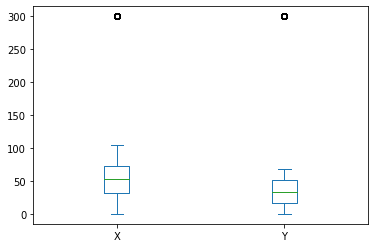

In [134]:
game_statistics[['X', 'Y']].plot.box()

In [135]:
game_statistics = game_statistics[game_statistics["X"] < 110]

game_statistics['Manager'].fillna("no_manager", inplace=True)

In [136]:
game_statistics["X"].min(), game_statistics["X"].max()

(0.0, 105.0)

In [137]:
game_statistics["Y"].min(), game_statistics["Y"].max()

(0.0, 68.0)

In [138]:
game_statistics["Out of Bounds"] = [(game_statistics["Y"] > 60) | (game_statistics["Y"] == 0) | (game_statistics["X"] > 100) | (game_statistics["X"] == 0)][0] *1
game_statistics["Corner"] = [((game_statistics["Y"] == 60) & ((game_statistics["X"] == 100) | (game_statistics["X"] == 0))) | ((game_statistics["Y"] == 0) & ((game_statistics["X"] == 100) | (game_statistics["X"] == 0)))][0] *1
game_statistics["Throw in"] = ([(game_statistics["Y"] > 60) | (game_statistics["Y"] == 0)][0] *1) - game_statistics["Corner"]
game_statistics["Goal kick first Team"] = [((game_statistics["Half"] == '2nd half') & (game_statistics["X"] > 100)) | ((game_statistics["Half"] == '1st half') & (game_statistics["X"] == 0))][0] *1
game_statistics["Goal kick second Team"] = [((game_statistics["Half"] == '1st half') & (game_statistics["X"] > 100)) | ((game_statistics["Half"] == '2nd half') & (game_statistics["X"] == 0))][0] *1

In [139]:
# fill missing values
game_statistics['next_player'].fillna(game_statistics[["Game_ID", "Player_ID"]].groupby(["Game_ID"]).shift(periods=-1).fillna(method='ffill')["Player_ID"], inplace=True)
game_statistics['next_x'].fillna(game_statistics[["Game_ID", "X"]].groupby(["Game_ID"]).shift(periods=-1).fillna(method='ffill')["X"], inplace=True) 
game_statistics['next_y'].fillna(game_statistics[["Game_ID", "Y"]].groupby(["Game_ID"]).shift(periods=-1).fillna(method='ffill')["Y"], inplace=True) 

In [140]:
game_statistics['X_diff'] = game_statistics['next_x'] - game_statistics['X']
game_statistics['Y_diff'] = game_statistics['next_y'] - game_statistics['Y']
game_statistics['Distance'] = np.sqrt(pow(game_statistics['X_diff']/1000 , 2) + pow(game_statistics['Y_diff']/1000 , 2) * 1.0) 
game_statistics['Time'] = (game_statistics['End_minutes'] - game_statistics['Start_minutes'])  /60
game_statistics['Ball_speed'] = game_statistics['Distance'] / game_statistics['Time']


game_statistics["Player_speed"] = list(map(lambda x: 0 if x in [0,1] else (1 if x in  [1,7] else (2 if x in  [7, 12] else (3 if x in  [12, 15] else (4 if x in [15, 20] else (5 if x in [20, 25] else (6 if x in [25, 40] else 7)))))), game_statistics["Ball_speed"].values))
#game_statistics["Player_speed"] = list(map(lambda x:"Standing" if x in [0,1] else ("Walking" if x in  [1,7] else ("Jogging" if x in  [7, 12] else ("Running" if x in  [12, 15] else ("Sprinting" if x in [15, 20] else ("High speed running" if x in [20, 25] else ("Maximum speed" if x in [25, 40] else "Long pass")))))), game_statistics["Ball_speed"].values))
game_statistics

,Game_ID,Player_ID,id,X,Y,Team,Half,Season,Manager,Opposition_Team,Shots,SoT,Accurate passes,Inaccurate passes,Passes,Start_minutes,End_minutes,next_player,next_action,next_x,next_y,event_id,next_team,next_event_id,xt_value,Out of Bounds,Corner,Throw in,Goal kick first Team,Goal kick second Team,X_diff,Y_diff,Distance,Time,Ball_speed,Player_speed
0,ID_ZZKYYPVY,Player_O7HO1NOB,1.0,52.5,34.0,Circinus,1st half,2,Ryoichi,Backward,0.0,0.0,1.0,0.0,1.0,0.03,0.37,Player_O7HO1NOB,NaN,52.5,34.0,NaN,NaN,NaN,NaN,0,0,0,0,0,0.0,0.0,0.000000,0.005667,0.000000,0
1,ID_ZZKYYPVY,Player_O7HO1NOB,2.0,52.5,34.0,Circinus,1st half,2,Ryoichi,Backward,0.0,0.0,0.0,0.0,0.0,0.03,0.37,Player_J0V7B0YE,NaN,37.0,32.7,NaN,NaN,NaN,NaN,0,0,0,0,0,-15.5,-1.3,0.015554,0.005667,2.744898,7
2,ID_ZZKYYPVY,Player_J0V7B0YE,3.0,37.0,32.7,Circinus,1st half,2,Ryoichi,Backward,0.0,0.0,0.0,0.0,0.0,0.05,0.38,Player_J0V7B0YE,NaN,39.5,33.0,NaN,NaN,NaN,NaN,0,0,0,0,0,2.5,0.3,0.002518,0.005500,0.457806,7
3,ID_ZZKYYPVY,Player_J0V7B0YE,4.0,39.5,33.0,Circinus,1st half,2,Ryoichi,Backward,0.0,0.0,0.0,0.0,0.0,0.07,0.40,Player_J0V7B0YE,NaN,39.5,33.0,NaN,NaN,NaN,NaN,0,0,0,0,0,0.0,0.0,0.000000,0.005500,0.000000,0
4,ID_ZZKYYPVY,Player_J0V7B0YE,5.0,39.5,33.0,Circinus,1st half,2,Ryoichi,Backward,0.0,0.0,0.0,1.0,1.0,0.07,0.40,Player_O9N837L0,NaN,34.5,1.4,NaN,NaN,NaN,NaN,0,0,0,0,0,-5.0,-31.6,0.031993,0.005500,5.816932,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802093,ID_03VRW8WV,Player_Y6ZZ2X44,3661.0,42.1,57.4,Antennae,2nd half,3,Elrick,Comet,0.0,0.0,0.0,0.0,0.0,96.33,96.67,Player_Y6ZZ2X44,NaN,42.1,57.4,2041.0,Antennae,2041.0,0.0,0,0,0,0,0,0.0,0.0,0.000000,0.005667,0.000000,0
802094,ID_03VRW8WV,Player_Y6ZZ2X44,3662.0,42.1,57.4,Antennae,2nd half,3,Elrick,Comet,0.0,0.0,0.0,0.0,0.0,96.33,96.67,Player_Y6ZZ2X44,NaN,42.1,57.4,2041.0,Antennae,2041.0,0.0,0,0,0,0,0,0.0,0.0,0.000000,0.005667,0.000000,0
802095,ID_03VRW8WV,Player_6DVBNW9L,3663.0,7.5,19.6,Comet,2nd half,3,Hideaki,Antennae,0.0,0.0,0.0,0.0,0.0,96.42,96.75,Player_6DVBNW9L,NaN,7.5,19.6,2042.0,Comet,2042.0,0.0,0,0,0,0,0,0.0,0.0,0.000000,0.005500,0.000000,0
802096,ID_03VRW8WV,Player_6DVBNW9L,3664.0,7.5,19.6,Comet,2nd half,3,Hideaki,Antennae,0.0,0.0,0.0,0.0,0.0,96.42,96.75,Player_77KCLG39,NaN,23.0,0.0,2042.0,Comet,2043.0,0.0,0,0,0,0,0,15.5,-19.6,0.024988,0.005500,4.543309,7


In [141]:
game_statistics.isnull().sum()

Game_ID                        0
Player_ID                      0
id                             0
X                              0
Y                              0
Team                           0
Half                           0
Season                         0
Manager                        0
Opposition_Team                0
Shots                          0
SoT                            0
Accurate passes                0
Inaccurate passes              0
Passes                         0
Start_minutes                  0
End_minutes                    0
next_player                    0
next_action              2413820
next_x                         0
next_y                         0
event_id                 1633674
next_team                1633887
next_event_id            1633890
xt_value                 1633674
Out of Bounds                  0
Corner                         0
Throw in                       0
Goal kick first Team           0
Goal kick second Team          0
X_diff    

# I/ Feature engineering

## 1 Exploring a single game

In [142]:
one_game = game_statistics.loc[game_statistics['Game_ID'] == game_statistics['Game_ID'].unique()[15]]

### 1.1 Exploring the ball target

In [143]:
X_Y = one_game[['Game_ID','X', 'Y']].groupby(['Game_ID']).diff().fillna(method='backfill')


X_Y = one_game[['Game_ID','X', 'Y']].groupby(['Game_ID']).diff().fillna(method='backfill')
X_Y.rename({'X':'X_diff', 'Y':'Y_diff'}, axis=1, inplace = True)
X_Y['Distance'] = np.sqrt(pow(X_Y['X_diff']/1000 , 2) + pow(X_Y['Y_diff']/1000 , 2) * 1.0) 
X_Y['Time'] = (one_game['End_minutes'] - one_game['Start_minutes'])  /60
X_Y['Ball_speed'] = X_Y['Distance'] / X_Y['Time']
X_Y

,X_diff,Y_diff,Distance,Time,Ball_speed
60918,0.0,0.0,0.000000,0.005000,0.000000
60919,0.0,0.0,0.000000,0.005000,0.000000
60920,6.6,9.6,0.011650,0.003667,3.177243
60921,-14.2,-7.5,0.016059,0.004500,3.568656
60922,-0.8,6.8,0.006847,0.004167,1.643255
...,...,...,...,...,...
65077,-6.4,0.3,0.006407,0.005500,1.164914
65078,1.5,-0.2,0.001513,0.005667,0.267048
65079,0.0,0.0,0.000000,0.005667,0.000000
65080,-45.8,60.2,0.075642,0.005667,13.348551


In [144]:
X_Y['Ball_speed'].min(), X_Y['Ball_speed'].max()  

(0.0, 21.017995255672563)

In [145]:
X_Y['Time'].min(), X_Y['Time'].max() * 60

(0.0028333333333333617, 0.8400000000000034)

In [146]:
X_Y['Distance'].min(), X_Y['Distance'].max()  *1000

(0.0, 119.1019731154778)

<AxesSubplot:>

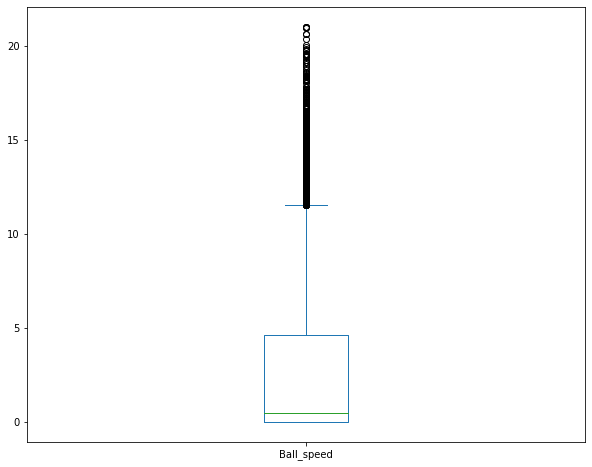

In [147]:
X_Y["Ball_speed"].plot.box(figsize=(10, 8))

<AxesSubplot:ylabel='Density'>

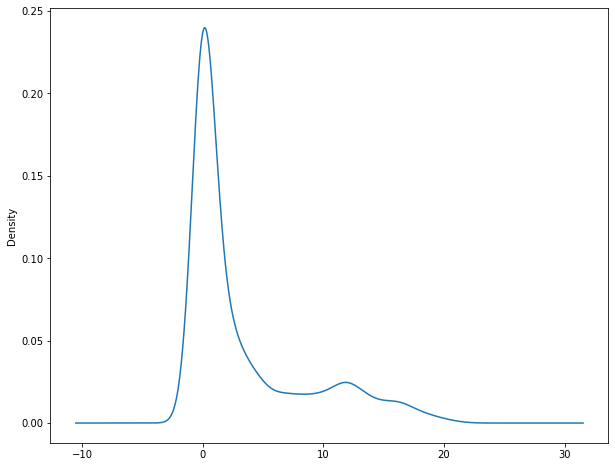

In [148]:
X_Y["Ball_speed"].plot.density(figsize=(10, 8))

<AxesSubplot:>

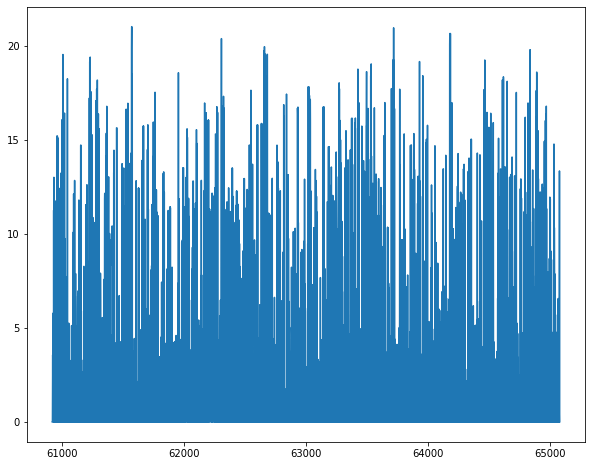

In [149]:
X_Y["Ball_speed"].plot.line(figsize=(10, 8))

<AxesSubplot:xlabel='Distance', ylabel='Ball_speed'>

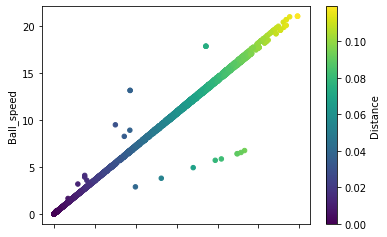

In [150]:
X_Y.plot.scatter(x='Distance', y='Ball_speed',c= 'Distance', colormap='viridis')

In [151]:
X_Y["Player_speed"] = list(map(lambda x: 0 if x in [0,1] else (1 if x in  [1,7] else (2 if x in  [7, 12] else (3 if x in  [12, 15] else (4 if x in [15, 20] else (5 if x in [20, 25] else (6 if x in [25, 40] else 7)))))), X_Y["Ball_speed"].values))
#X_Y["Player_speed"] = list(map(lambda x:"Standing" if x in [0,1] else ("Walking" if x in  [1,7] else ("Jogging" if x in  [7, 12] else ("Running" if x in  [12, 15] else ("Sprinting" if x in [15, 20] else ("High speed running" if x in [20, 25] else ("Maximum speed" if x in [25, 40] else "Long pass")))))), X_Y["Ball_speed"].values))
X_Y

,X_diff,Y_diff,Distance,Time,Ball_speed,Player_speed
60918,0.0,0.0,0.000000,0.005000,0.000000,0
60919,0.0,0.0,0.000000,0.005000,0.000000,0
60920,6.6,9.6,0.011650,0.003667,3.177243,7
60921,-14.2,-7.5,0.016059,0.004500,3.568656,7
60922,-0.8,6.8,0.006847,0.004167,1.643255,7
...,...,...,...,...,...,...
65077,-6.4,0.3,0.006407,0.005500,1.164914,7
65078,1.5,-0.2,0.001513,0.005667,0.267048,7
65079,0.0,0.0,0.000000,0.005667,0.000000,0
65080,-45.8,60.2,0.075642,0.005667,13.348551,7


### 1.2 Exploring a single player

<AxesSubplot:>

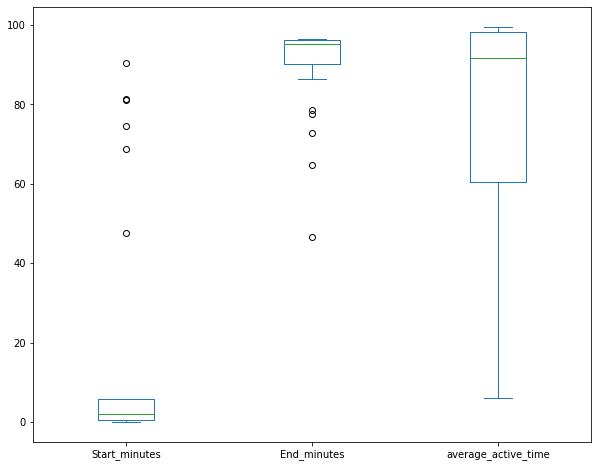

In [152]:
one_player_in_game = one_game.loc[one_game['Player_ID'] == one_game['Player_ID'].unique()[3]]

one_player_in_game = one_game.groupby(['Player_ID']).min()[['Start_minutes', 'End_minutes']]
one_player_in_game['End_minutes'] = one_game.groupby(['Player_ID']).max()[['End_minutes']]
one_player_in_game["average_active_time"] = ((one_player_in_game["End_minutes"] - one_player_in_game["Start_minutes"]) / one_player_in_game["End_minutes"].values.max()) * 100
one_player_in_game["reserve_player"] = (one_player_in_game["average_active_time"].values < 0.5).tolist()
one_player_in_game["starting_player"] = (one_player_in_game["Start_minutes"].values < 45).tolist()

one_player_in_game.plot.box(figsize=(10, 8))

### Exploring a single team

In [153]:
one_team = game_statistics.loc[game_statistics['Team'] == game_statistics['Team'].unique()[1]]

grouped = game_statistics[["Game_ID", "Opposition_Team", "Manager", "Player_ID", "Passes","Accurate passes", "Inaccurate passes", "Shots",	"SoT"]].groupby(["Game_ID", "Opposition_Team", "Manager", "Player_ID"]).sum()
grouped.rename({'Passes':'nb of Passes', 'Accurate passes':'nb of Accurate passes', 'Inaccurate passes': 'nb of Inaccurate passes', "Shots": 'nb of Shots',	"SoT": 'nb of SoT'}, axis=1, inplace = True)

grouped["nb of Games"] = len(grouped.index.get_level_values(0).unique())
grouped["nb of Opposition teams"] = len(grouped.index.get_level_values(1).unique())
grouped["nb of Managers"] = len(grouped.index.get_level_values(2).unique())
grouped["nb of Players"] = len(grouped.index.get_level_values(3).unique())
grouped["nb of one round tournaments"] = grouped["nb of Games"] - grouped["nb of Opposition teams"]
grouped.head()

nb of Passes  \
Game_ID     Opposition_Team Manager Player_ID                       
ID_00EFNL7L Butterfly       Masashi Player_0F087PWX          29.0   
                                    Player_0S25K20U           1.0   
                                    Player_10WKX99Y          39.0   
                                    Player_30LIPYOT          36.0   
                                    Player_5CBBVY85           3.0   

                                                     nb of Accurate passes  \
Game_ID     Opposition_Team Manager Player_ID                                
ID_00EFNL7L Butterfly       Masashi Player_0F087PWX                   17.0   
                                    Player_0S25K20U                    1.0   
                                    Player_10WKX99Y                   26.0   
                                    Player_30LIPYOT                   28.0   
                                    Player_5CBBVY85                    2.0   

                                                     nb of Inaccurate passes  \
Game_ID     Opposition_Team Manager Player_ID                                  
ID_00EFNL7L Butterfly       Masashi Player_0F087PWX                     12.0   
                                    Player_0S25K20U                      0.0   
                                    Player_10WKX99Y                     13.0   
                                    Player_30LIPYOT                      8.0   
                                    Player_5CBBVY85                      1.0   

                                                     nb of Shots  nb of SoT  \
Game_ID     Opposition_Team Manager Player_ID                                 
ID_00EFNL7L Butterfly       Masashi Player_0F087PWX          0.0        0.0   
                                    Player_0S25K20U          0.0        0.0   
                                    Player_10WKX99Y          1.0        0.0   
                                    Player_30LIPYOT          0.0        0.0   
                                    Player_5CBBVY85          3.0        0.0   

                                                     nb of Games  \
Game_ID     Opposition_Team Manager Player_ID                      
ID_00EFNL7L Butterfly       Masashi Player_0F087PWX          624   
                                    Player_0S25K20U          624   
                                    Player_10WKX99Y          624   
                                    Player_30LIPYOT          624   
                                    Player_5CBBVY85          624   

                                                     nb of Opposition teams  \
Game_ID     Opposition_Team Manager Player_ID                                 
ID_00EFNL7L Butterfly       Masashi Player_0F087PWX                      22   
                                    Player_0S25K20U                      22   
                                    Player_10WKX99Y                      22   
                                    Player_30LIPYOT                      22   
                                    Player_5CBBVY85                      22   

                                                     nb of Managers  \
Game_ID     Opposition_Team Manager Player_ID                         
ID_00EFNL7L Butterfly       Masashi Player_0F087PWX              65   
                                    Player_0S25K20U              65   
                                    Player_10WKX99Y              65   
                                    Player_30LIPYOT              65   
                                    Player_5CBBVY85              65   

                                                     nb of Players  \
Game_ID     Opposition_Team Manager Player_ID                        
ID_00EFNL7L Butterfly       Masashi Player_0F087PWX            802   
                                    Player_0S25K20U            802   
                                    Player_10WKX99Y            802   
                            

In [154]:
Counter(grouped.index.get_level_values(2)).most_common()

[('Jiraya', 1245),
 ('Hideaki', 1232),
 ('Masashi', 1112),
 ('Dante', 971),
 ('Isamu', 968),
 ('Akuma/Inuyasha', 901),
 ('Elrick', 841),
 ('Tatsuya', 797),
 ('Ryoichi', 728),
 ('Ryuu', 722),
 ('Noburu', 671),
 ('Nikushimi', 616),
 ('Daiki', 579),
 ('Megumi', 560),
 ('Bodo/Drogo', 435),
 ('Levi', 428),
 ('Rufus', 384),
 ('Frodo', 366),
 ('Karatachi', 363),
 ('Kepli', 316),
 ('Roy', 291),
 ('Alex', 288),
 ('Kouta', 272),
 ('Cottar', 269),
 ('Alphonse', 252),
 ('Barner', 197),
 ('Osamu', 195),
 ('Rorimac', 182),
 ('Hideo', 175),
 ('Zankoku/Garret', 174),
 ('Haldon', 172),
 ('Kouki', 153),
 ('Youkai', 153),
 ('Brock', 143),
 ('Adric', 133),
 ('Devix', 124),
 ('Tanjiro', 108),
 ('Valkas/Gokin', 106),
 ('Hikaru', 104),
 ('Ash', 84),
 ('Otho', 75),
 ('Joyas', 74),
 ('Seiji', 71),
 ('Tenzin', 69),
 ('Yami', 62),
 ('Dudo/Eder', 59),
 ('Largo', 59),
 ('Andwise/Hob', 48),
 ('Akui', 46),
 ('no_manager', 43),
 ('Hornblower', 41),
 ('Aoiro', 41),
 ('Tarkas/Adelard', 41),
 ('Balbo', 32),
 ('Beau', 30

In [155]:
Counter(grouped.index.get_level_values(1)).most_common()

[('Medusa Merger', 1313),
 ('Cigar', 1297),
 ('Cosmos Redshift 7', 1288),
 ('Comet', 1271),
 ('Fireworks', 1265),
 ('Milky Way', 1260),
 ('Antennae', 1253),
 ('Cartwheel', 1237),
 ('Backward', 1080),
 ('Circinus', 1054),
 ('Andromeda', 938),
 ('Sunflower', 882),
 ('Coma Pinwheel', 742),
 ('Tadpole', 706),
 ('Sculptor', 674),
 ('Whirlpool', 393),
 ('Butterfly', 377),
 ('Malin 1', 371),
 ('Eye of Sauron', 367),
 ('Triangulum', 363),
 ('Sombrero', 350),
 ('Needle', 308)]

In [156]:
len(grouped.index.get_level_values(0).unique()), len(grouped.index.get_level_values(1).unique()), len(grouped.index.get_level_values(2).unique())

(624, 22, 65)

In [157]:
game_statistics['Team'].unique()[1], len(one_team["Opposition_Team"].unique()), one_team["Manager"].unique(), len(one_team["Game_ID"].unique())

('Backward',
 20,
 array(['Karatachi', 'Osamu', 'Daiki', 'Haldon', 'Adric', 'Hornblower'],
       dtype=object),
 71)

In [158]:
one_team = game_statistics.loc[game_statistics['Team'] == game_statistics['Team'].unique()[1]]

grouped = one_team[["Game_ID", "Opposition_Team", "Manager", "Player_ID", "Passes","Accurate passes", "Inaccurate passes", "Shots",	"SoT"]].groupby(["Game_ID", "Opposition_Team", "Manager", "Player_ID"]).sum()
grouped.rename({'Passes':'nb of Passes', 'Accurate passes':'nb of Accurate passes', 'Inaccurate passes': 'nb of Inaccurate passes', "Shots": 'nb of Shots',	"SoT": 'nb of SoT'}, axis=1, inplace = True)

grouped["nb of Games"] = len(grouped.index.get_level_values(0).unique())
grouped["nb of Opposition teams"] = len(grouped.index.get_level_values(1).unique())
grouped["nb of Managers"] = len(grouped.index.get_level_values(2).unique())
grouped["nb of Players"] = len(grouped.index.get_level_values(3).unique())
grouped["nb of one round tournaments"] = grouped["nb of Games"] - grouped["nb of Opposition teams"]
grouped.head()

nb of Passes  \
Game_ID     Opposition_Team Manager Player_ID                       
ID_00J124MI Medusa Merger   Osamu   Player_2E1DKGPZ          21.0   
                                    Player_4Q3DO4ON           6.0   
                                    Player_BIHO4TQG          19.0   
                                    Player_D8XXLMMD          21.0   
                                    Player_HGGSFAZB          26.0   

                                                     nb of Accurate passes  \
Game_ID     Opposition_Team Manager Player_ID                                
ID_00J124MI Medusa Merger   Osamu   Player_2E1DKGPZ                   20.0   
                                    Player_4Q3DO4ON                    5.0   
                                    Player_BIHO4TQG                   17.0   
                                    Player_D8XXLMMD                   18.0   
                                    Player_HGGSFAZB                   24.0   

                                                     nb of Inaccurate passes  \
Game_ID     Opposition_Team Manager Player_ID                                  
ID_00J124MI Medusa Merger   Osamu   Player_2E1DKGPZ                      1.0   
                                    Player_4Q3DO4ON                      1.0   
                                    Player_BIHO4TQG                      2.0   
                                    Player_D8XXLMMD                      3.0   
                                    Player_HGGSFAZB                      2.0   

                                                     nb of Shots  nb of SoT  \
Game_ID     Opposition_Team Manager Player_ID                                 
ID_00J124MI Medusa Merger   Osamu   Player_2E1DKGPZ          0.0        0.0   
                                    Player_4Q3DO4ON          0.0        0.0   
                                    Player_BIHO4TQG          2.0        1.0   
                                    Player_D8XXLMMD          0.0        0.0   
                                    Player_HGGSFAZB          4.0        2.0   

                                                     nb of Games  \
Game_ID     Opposition_Team Manager Player_ID                      
ID_00J124MI Medusa Merger   Osamu   Player_2E1DKGPZ           71   
                                    Player_4Q3DO4ON           71   
                                    Player_BIHO4TQG           71   
                                    Player_D8XXLMMD           71   
                                    Player_HGGSFAZB           71   

                                                     nb of Opposition teams  \
Game_ID     Opposition_Team Manager Player_ID                                 
ID_00J124MI Medusa Merger   Osamu   Player_2E1DKGPZ                      20   
                                    Player_4Q3DO4ON                      20   
                                    Player_BIHO4TQG                      20   
                                    Player_D8XXLMMD                      20   
                                    Player_HGGSFAZB                      20   

                                                     nb of Managers  \
Game_ID     Opposition_Team Manager Player_ID                         
ID_00J124MI Medusa Merger   Osamu   Player_2E1DKGPZ               6   
                                    Player_4Q3DO4ON               6   
                                    Player_BIHO4TQG               6   
                                    Player_D8XXLMMD               6   
                                    Player_HGGSFAZB               6   

                                                     nb of Players  \
Game_ID     Opposition_Team Manager Player_ID                        
ID_00J124MI Medusa Merger   Osamu   Player_2E1DKGPZ             72   
                                    Player_4Q3DO4ON             72   
                                    Player_BIHO4TQG             72   
                            

In [159]:
### 1.3 Globalisation

In [160]:
min_player_by_game = game_statistics[['Player_ID', 'Game_ID', 'Start_minutes', 'Manager', 'Team', 'Opposition_Team']].groupby(['Game_ID', 'Player_ID', 'Team', 'Manager', 'Opposition_Team']).min()
min_player_by_game.rename({'Start_minutes':'min_Start_minutes'}, axis=1, inplace = True)

max_player_by_game = game_statistics[['Player_ID', 'Game_ID', 'End_minutes', 'Manager', 'Team', 'Opposition_Team']].groupby(['Game_ID', 'Player_ID', 'Team', 'Manager', 'Opposition_Team']).max()
max_player_by_game.rename({'End_minutes':'max_End_minutes'}, axis=1, inplace = True)

player_by_game = pd.concat([min_player_by_game, max_player_by_game], axis = 1)

player_by_game["average_active_time"] = ((player_by_game["max_End_minutes"] - player_by_game["min_Start_minutes"]) / player_by_game["max_End_minutes"].values.max()) # * 100
player_by_game["reserve_player"] = (player_by_game["average_active_time"].values < 0.5) * 1
player_by_game["starting_player"] = (player_by_game["min_Start_minutes"].values < 45) * 1

player_by_game.head(2)

min_Start_minutes  \
Game_ID     Player_ID       Team      Manager Opposition_Team                      
ID_00EFNL7L Player_033SPDRN Butterfly Dante   Milky Way                      0.7   
            Player_0F087PWX Milky Way Masashi Butterfly                      3.3   

                                                               max_End_minutes  \
Game_ID     Player_ID       Team      Manager Opposition_Team                    
ID_00EFNL7L Player_033SPDRN Butterfly Dante   Milky Way                  98.15   
            Player_0F087PWX Milky Way Masashi Butterfly                  96.97   

                                                               average_active_time  \
Game_ID     Player_ID       Team      Manager Opposition_Team                        
ID_00EFNL7L Player_033SPDRN Butterfly Dante   Milky Way                   0.850720   
            Player_0F087PWX Milky Way Masashi Butterfly                   0.817722   

                                                               reserve_player  \
Game_ID     Player_ID       Team      Manager Opposition_Team                   
ID_00EFNL7L Player_033SPDRN Butterfly Dante   Milky Way                     0   
            Player_0F087PWX Milky Way Masashi Butterfly                     0   

                                                               starting_player  
Game_ID     Player_ID       Team      Manager Opposition_Team                   
ID_00EFNL7L Player_033SPDRN Butterfly Dante   Milky Way                      1  
            Player_0F087PWX Milky Way Masashi Butterfly                      1

In [161]:
groupedby_team = game_statistics[['Game_ID', 'Player_ID', 'Team', 'Manager', 'Opposition_Team', 'Shots', 'SoT', 'Accurate passes',
       'Inaccurate passes', 'Passes', 'Out of Bounds', 'Corner',
       'Throw in', 'Goal kick first Team', 'Goal kick second Team']].groupby(["Game_ID", 'Team', "Manager", "Opposition_Team", "Player_ID"]).sum()
groupedby_team.rename({'Passes':'nb of Passes', 'Accurate passes':'nb of Accurate passes', 'Inaccurate passes': 'nb of Inaccurate passes', "Shots": 'nb of Shots',	"SoT": 'nb of SoT'}, axis=1, inplace = True)

groupedby_team.head(2)

nb of Shots  \
Game_ID     Team      Manager Opposition_Team Player_ID                      
ID_00EFNL7L Butterfly Dante   Milky Way       Player_033SPDRN          0.0   
                                              Player_1EMBIZVU          3.0   

                                                               nb of SoT  \
Game_ID     Team      Manager Opposition_Team Player_ID                    
ID_00EFNL7L Butterfly Dante   Milky Way       Player_033SPDRN        0.0   
                                              Player_1EMBIZVU        0.0   

                                                               nb of Accurate passes  \
Game_ID     Team      Manager Opposition_Team Player_ID                                
ID_00EFNL7L Butterfly Dante   Milky Way       Player_033SPDRN                   34.0   
                                              Player_1EMBIZVU                   31.0   

                                                               nb of Inaccurate passes  \
Game_ID     Team      Manager Opposition_Team Player_ID                                  
ID_00EFNL7L Butterfly Dante   Milky Way       Player_033SPDRN                     11.0   
                                              Player_1EMBIZVU                     12.0   

                                                               nb of Passes  \
Game_ID     Team      Manager Opposition_Team Player_ID                       
ID_00EFNL7L Butterfly Dante   Milky Way       Player_033SPDRN          45.0   
                                              Player_1EMBIZVU          43.0   

                                                               Out of Bounds  \
Game_ID     Team      Manager Opposition_Team Player_ID                        
ID_00EFNL7L Butterfly Dante   Milky Way       Player_033SPDRN            133   
                                              Player_1EMBIZVU            123   

                                                               Corner  \
Game_ID     Team      Manager Opposition_Team Player_ID                 
ID_00EFNL7L Butterfly Dante   Milky Way       Player_033SPDRN       3   
                                              Player_1EMBIZVU       2   

                                                               Throw in  \
Game_ID     Team      Manager Opposition_Team Player_ID                   
ID_00EFNL7L Butterfly Dante   Milky Way       Player_033SPDRN       124   
                                              Player_1EMBIZVU       119   

                                                               Goal kick first Team  \
Game_ID     Team      Manager Opposition_Team Player_ID                               
ID_00EFNL7L Butterfly Dante   Milky Way       Player_033SPDRN                     2   
                                              Player_1EMBIZVU                    10   

                                                               Goal kick second Team  
Game_ID     Team      Manager Opposition_Team Player_ID                               
ID_00EFNL7L Butterfly Dante   Milky Way       Player_033SPDRN                      8  
                                              Player_1EMBIZVU                      1

In [162]:
grouped_game_statistics = groupedby_team.join(player_by_game)
grouped_game_statistics.head(2)

nb of Shots  \
Game_ID     Team      Manager Opposition_Team Player_ID                      
ID_00EFNL7L Butterfly Dante   Milky Way       Player_033SPDRN          0.0   
                                              Player_1EMBIZVU          3.0   

                                                               nb of SoT  \
Game_ID     Team      Manager Opposition_Team Player_ID                    
ID_00EFNL7L Butterfly Dante   Milky Way       Player_033SPDRN        0.0   
                                              Player_1EMBIZVU        0.0   

                                                               nb of Accurate passes  \
Game_ID     Team      Manager Opposition_Team Player_ID                                
ID_00EFNL7L Butterfly Dante   Milky Way       Player_033SPDRN                   34.0   
                                              Player_1EMBIZVU                   31.0   

                                                               nb of Inaccurate passes  \
Game_ID     Team      Manager Opposition_Team Player_ID                                  
ID_00EFNL7L Butterfly Dante   Milky Way       Player_033SPDRN                     11.0   
                                              Player_1EMBIZVU                     12.0   

                                                               nb of Passes  \
Game_ID     Team      Manager Opposition_Team Player_ID                       
ID_00EFNL7L Butterfly Dante   Milky Way       Player_033SPDRN          45.0   
                                              Player_1EMBIZVU          43.0   

                                                               Out of Bounds  \
Game_ID     Team      Manager Opposition_Team Player_ID                        
ID_00EFNL7L Butterfly Dante   Milky Way       Player_033SPDRN            133   
                                              Player_1EMBIZVU            123   

                                                               Corner  \
Game_ID     Team      Manager Opposition_Team Player_ID                 
ID_00EFNL7L Butterfly Dante   Milky Way       Player_033SPDRN       3   
                                              Player_1EMBIZVU       2   

                                                               Throw in  \
Game_ID     Team      Manager Opposition_Team Player_ID                   
ID_00EFNL7L Butterfly Dante   Milky Way       Player_033SPDRN       124   
                                              Player_1EMBIZVU       119   

                                                               Goal kick first Team  \
Game_ID     Team      Manager Opposition_Team Player_ID                               
ID_00EFNL7L Butterfly Dante   Milky Way       Player_033SPDRN                     2   
                                              Player_1EMBIZVU                    10   

                                                               Goal kick second Team  \
Game_ID     Team      Manager Opposition_Team Player_ID                                
ID_00EFNL7L Butterfly Dante   Milky Way       Player_033SPDRN                      8   
                                              Player_1EMBIZVU                      1   

                                                               min_Start_minutes  \
Game_ID     Team      Manager Opposition_Team Player_ID                            
ID_00EFNL7L Butterfly Dante   Milky Way       Player_033SPDRN               0.70   
                                              Player_1EMBIZVU               1.32   

                                                               max_End_minutes  \
Game_ID     Team      Manager Opposition_Team Player_ID                          
ID_00EFNL7L Butterfly Dante   Milky Way       Player_033SPDRN            98.15   
                                              Player_1EMBIZVU            94.28   

                                                               average_active_time  \
Game_ID     Team      Manager Opposition_Team

In [163]:
len(grouped_game_statistics.index.get_level_values(0).unique()),len(grouped_game_statistics.index.get_level_values(1).unique()), len(grouped_game_statistics.index.get_level_values(2).unique()), len(grouped_game_statistics.index.get_level_values(3).unique()),len(grouped_game_statistics.index.get_level_values(4).unique())

(624, 22, 65, 22, 802)

In [164]:
groupedby_team.groupby(level=[1]).sum().head()

,nb of Shots,nb of SoT,nb of Accurate passes,nb of Inaccurate passes,nb of Passes,Out of Bounds,Corner,Throw in,Goal kick first Team,Goal kick second Team
Team,,,,,,,,,,
Andromeda,551.0,137.0,24281.0,5819.0,30100.0,21325,563,18881,2173,1710
Antennae,800.0,202.0,31445.0,7497.0,38942.0,28763,763,25547,2749,2461
Backward,800.0,203.0,19724.0,6392.0,26116.0,20537,609,17702,2437,2069
Butterfly,298.0,83.0,9848.0,2506.0,12354.0,10427,245,9401,935,831
Cartwheel,851.0,231.0,39534.0,6951.0,46485.0,29136,831,25541,2767,2603


In [165]:
groupedby_team.groupby(level=[3]).sum().head()

,nb of Shots,nb of SoT,nb of Accurate passes,nb of Inaccurate passes,nb of Passes,Out of Bounds,Corner,Throw in,Goal kick first Team,Goal kick second Team
Opposition_Team,,,,,,,,,,
Andromeda,582.0,147.0,23916.0,5793.0,29709.0,21154,622,18702,2042,1834
Antennae,809.0,230.0,33330.0,7498.0,40828.0,27781,640,24521,2882,2435
Backward,828.0,230.0,30839.0,6647.0,37486.0,25557,636,22674,2520,2325
Butterfly,264.0,68.0,9515.0,2393.0,11908.0,8362,229,7596,530,742
Cartwheel,858.0,235.0,28342.0,6992.0,35334.0,24892,796,21737,2673,2341


In [166]:
Train.shape, Test.shape, game_statistics.shape

((412, 7), (234, 6), (2428009, 36))

In [167]:
Train.isna().sum()

Date         0
Season       0
Match_ID     0
Game_ID      0
Home Team    0
Away Team    0
Score        0
dtype: int64

In [168]:
Test.isna().sum()

Date         0
Season       0
Match_ID     0
Game_ID      0
Home Team    0
Away Team    0
dtype: int64

In [169]:
game_statistics.isna().sum()

Game_ID                        0
Player_ID                      0
id                             0
X                              0
Y                              0
Team                           0
Half                           0
Season                         0
Manager                        0
Opposition_Team                0
Shots                          0
SoT                            0
Accurate passes                0
Inaccurate passes              0
Passes                         0
Start_minutes                  0
End_minutes                    0
next_player                    0
next_action              2413820
next_x                         0
next_y                         0
event_id                 1633674
next_team                1633887
next_event_id            1633890
xt_value                 1633674
Out of Bounds                  0
Corner                         0
Throw in                       0
Goal kick first Team           0
Goal kick second Team          0
X_diff    

In [170]:
#Replacing the missing values with mean of each columns
#game_statistics.fillna(game_statistics.mean(), inplace=True)

### Data EDA and Visualisation.

- Lets analyze the data provided by anaswering some few questions

In [171]:
Train.describe()

,Season,Match_ID
count,412.000000,412.000000
mean,1.497573,109.536408
std,0.500602,63.273255
min,1.000000,1.000000
25%,1.000000,54.750000
50%,1.000000,110.000000
75%,2.000000,165.000000
max,2.000000,224.000000


In [172]:
Test.describe()

,Season,Match_ID
count,234.0,234.000000
mean,3.0,126.581197
std,0.0,81.669568
min,3.0,2.000000
25%,3.0,60.250000
50%,3.0,119.500000
75%,3.0,179.750000
max,3.0,300.000000


In [173]:
game_statistics.describe()

,id,X,Y,Season,Shots,SoT,Accurate passes,Inaccurate passes,Passes,Start_minutes,End_minutes,next_x,next_y,event_id,next_event_id,xt_value,Out of Bounds,Corner,Throw in,Goal kick first Team,Goal kick second Team,X_diff,Y_diff,Distance,Time,Ball_speed,Player_speed
count,2.428009e+06,2.428009e+06,2.428009e+06,2.428009e+06,2.428009e+06,2.428009e+06,2.428009e+06,2.428009e+06,2.428009e+06,2.428009e+06,2.428009e+06,2.428009e+06,2.428009e+06,794335.000000,794119.000000,794335.000000,2.428009e+06,2.428009e+06,2.428009e+06,2.428009e+06,2.428009e+06,2.428009e+06,2.428009e+06,2.428009e+06,2.428009e+06,2.428009e+06,2.428009e+06
mean,1.895216e+03,5.246686e+01,3.375015e+01,1.986798e+00,5.358712e-03,1.438215e-03,1.953687e-01,4.569876e-02,2.410675e-01,4.790339e+01,4.823737e+01,5.292746e+01,3.376098e+01,1046.752256,1047.036944,0.000905,1.695887e-01,4.660197e-03,1.493977e-01,1.686608e-02,1.556419e-02,4.606047e-01,1.083209e-02,1.912026e-02,5.566378e-03,3.433849e+00,4.048064e+00
std,1.109534e+03,2.679720e+01,2.033144e+01,8.169073e-01,7.300684e-02,3.789654e-02,3.964844e-01,2.088310e-01,4.277313e-01,2.858132e+01,2.858153e+01,2.679344e+01,2.033221e+01,612.145178,611.984937,0.010542,3.752712e-01,6.810640e-02,3.564801e-01,1.287697e-01,1.237819e-01,2.734812e+01,1.915333e+01,2.737512e-02,3.365102e-04,4.918304e+00,3.456824e+00
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.700000e-01,0.000000e+00,0.000000e+00,0.000000,0.000000,-0.233602,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.050000e+02,-6.800000e+01,0.000000e+00,2.666667e-03,0.000000e+00,0.000000e+00
25%,9.410000e+02,3.200000e+01,1.610000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.277000e+01,2.310000e+01,3.240000e+01,1.610000e+01,522.000000,522.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.600000e+00,0.000000e+00,5.500000e-03,0.000000e+00,0.000000e+00
50%,1.881000e+03,5.250000e+01,3.380000e+01,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.750000e+01,4.783000e+01,5.350000e+01,3.380000e+01,1039.000000,1039.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.015974e-03,5.500000e-03,9.027048e-01,7.000000e+00
75%,2.821000e+03,7.330000e+01,5.140000e+01,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.250000e+01,7.283000e+01,7.370000e+01,5.140000e+01,1554.000000,1554.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,1.500000e+00,2.852806e-02,5.666667e-03,5.123274e+00,7.000000e+00
max,4.698000e+03,1.050000e+02,6.800000e+01,3.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.139700e+02,1.145500e+02,1.050000e+02,6.800000e+01,2667.000000,2667.000000,0.248043,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.050000e+02,6.800000e+01,1.250960e-01,1.400000e-02,3.710263e+01,7.000000e+00


#### How many seasons are in train and test ?

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Season', ylabel='count'>

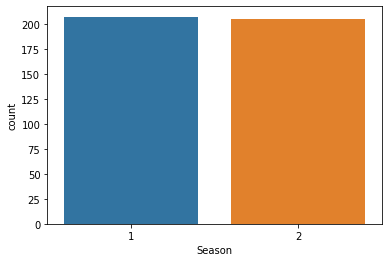

In [174]:
sns.countplot(Train["Season"])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Season', ylabel='count'>

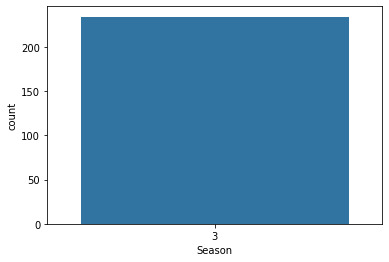

In [175]:
sns.countplot(Test["Season"])

- We can see that 2 seasons are provided in the training data while one season is provided in the the test

#### How many unique match IDs are provided?

- From a football perspective, can you find out what's a match, are matches specific to every season?

In [176]:
Train.Match_ID.nunique()

224

In [177]:
Test.Match_ID.nunique()

213

#### How many games were played in train seasons and test seasons?

In [178]:
Train.Game_ID.nunique()

412

In [179]:
Test.Game_ID.nunique()

234

#### How many teams were away and home?

In [180]:
Train["Home Team"].nunique()

19

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Home Team', ylabel='count'>

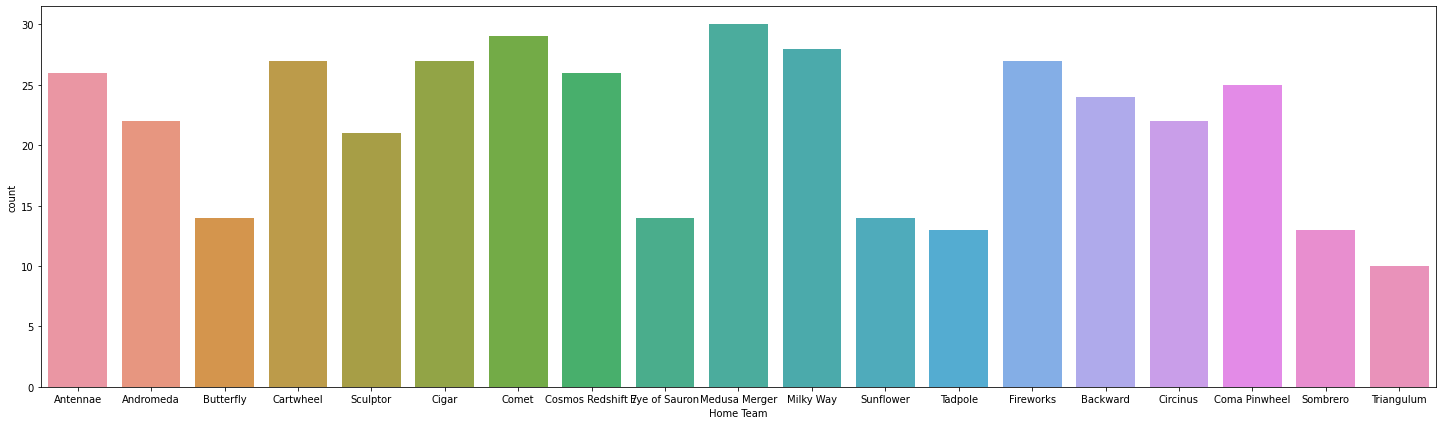

In [181]:
plt.figure(figsize=(25,7))
sns.countplot(Train["Home Team"])

In [182]:
Train["Away Team"].nunique()

19

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Away Team', ylabel='count'>

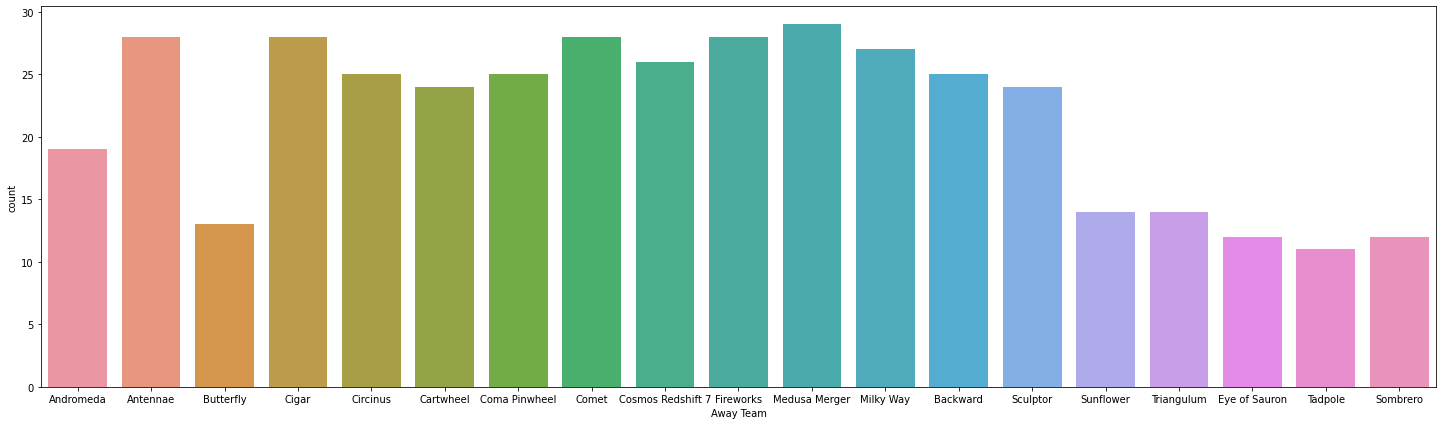

In [183]:
plt.figure(figsize=(25,7))
sns.countplot(Train["Away Team"])

In [184]:
Test["Home Team"].nunique()

16

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Home Team', ylabel='count'>

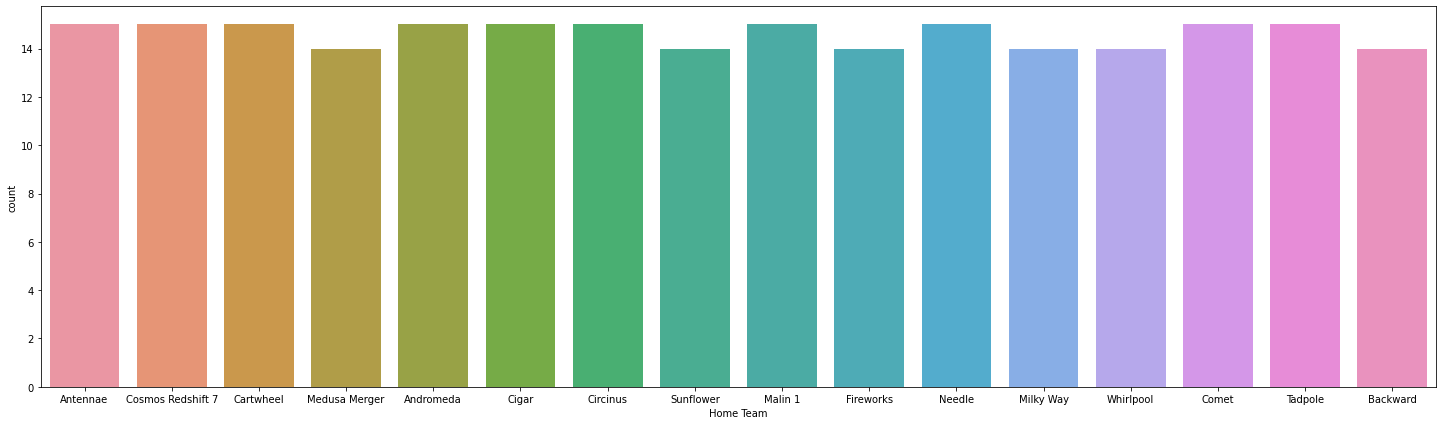

In [185]:
plt.figure(figsize=(25,7))
sns.countplot(Test["Home Team"])

In [186]:
Test["Away Team"].nunique()

16

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Away Team', ylabel='count'>

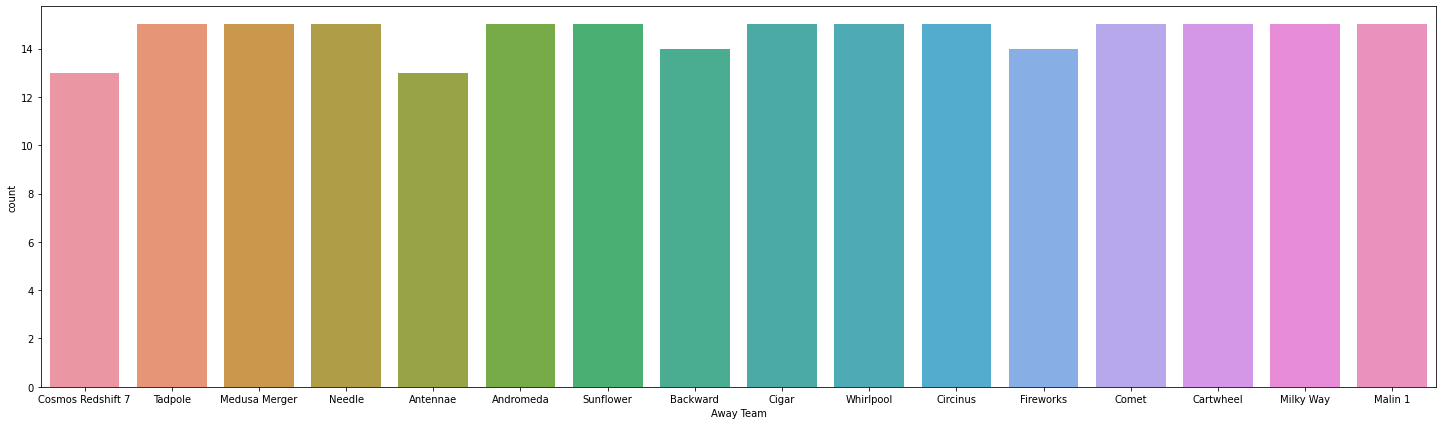

In [187]:
plt.figure(figsize=(25,7))
sns.countplot(Test["Away Team"])

In [188]:
# All teams are listed
train_teams = set(list(Train['Home Team'].unique()) + list(Train['Away Team'].unique()))
test_teams = set(list(Test['Home Team'].unique()) + list(Test['Away Team'].unique()))
len(train_teams), len(test_teams)

(19, 16)

In [189]:
set(train_teams) - set(test_teams)

{'Butterfly',
 'Coma Pinwheel',
 'Eye of Sauron',
 'Sculptor',
 'Sombrero',
 'Triangulum'}

In [190]:
set(test_teams) - set(train_teams) 

{'Malin 1', 'Needle', 'Whirlpool'}

- We can see that the number of teams in Home and away are equal in both cases, however the test count of the teams is more balance than the train, could this be as a result of 1 season in test and 2 seasons in the train? For the train can you countplot per season?

#### Did the team Win, Lose or Draw?

- Let's look at the target column, the reason for creating our machine leaning model, the goal of every footbal game is to determine the winner

In [191]:
Train["Score"].nunique()

3

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Score', ylabel='count'>

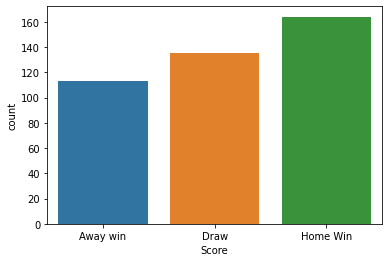

In [192]:
sns.countplot(Train["Score"])

We have 3 classifications, did the away team win, did both teams draw or did the home team win? We can see that in most cases the home team won. There's much more you can do with this field:

    - Look at every team, the number of games played? did they win or lose, are most of their wins during home or away game?

- **You can do more EDAs on the game statistics file**

### Feature Engineering and Modelling

#### Game statistics 

- This file shows how the game was played from start to end, the actions of the game, which player was it passed to etc.
- We will need to merge this with the train and test data provided.

In [193]:
Train["Train"] = 1
Test["Train"]= 0

train_test = pd.concat([Train, Test])

In [194]:
train_test.shape

(646, 8)

In [195]:
train_test.head(3)

,Date,Season,Match_ID,Game_ID,Home Team,Away Team,Score,Train
0,2017-02-15,1,1.0,ID_KAG4KAE9,Antennae,Andromeda,Away win,1
1,2016-09-14,1,12.0,ID_T7H1XN5Z,Andromeda,Antennae,Draw,1
2,2016-12-12,1,13.0,ID_O1P9FGN4,Andromeda,Butterfly,Away win,1


In [196]:
game_statistics.head(3)

,Game_ID,Player_ID,id,X,Y,Team,Half,Season,Manager,Opposition_Team,Shots,SoT,Accurate passes,Inaccurate passes,Passes,Start_minutes,End_minutes,next_player,next_action,next_x,next_y,event_id,next_team,next_event_id,xt_value,Out of Bounds,Corner,Throw in,Goal kick first Team,Goal kick second Team,X_diff,Y_diff,Distance,Time,Ball_speed,Player_speed
0,ID_ZZKYYPVY,Player_O7HO1NOB,1.0,52.5,34.0,Circinus,1st half,2,Ryoichi,Backward,0.0,0.0,1.0,0.0,1.0,0.03,0.37,Player_O7HO1NOB,NaN,52.5,34.0,NaN,NaN,NaN,NaN,0,0,0,0,0,0.0,0.0,0.000000,0.005667,0.000000,0
1,ID_ZZKYYPVY,Player_O7HO1NOB,2.0,52.5,34.0,Circinus,1st half,2,Ryoichi,Backward,0.0,0.0,0.0,0.0,0.0,0.03,0.37,Player_J0V7B0YE,NaN,37.0,32.7,NaN,NaN,NaN,NaN,0,0,0,0,0,-15.5,-1.3,0.015554,0.005667,2.744898,7
2,ID_ZZKYYPVY,Player_J0V7B0YE,3.0,37.0,32.7,Circinus,1st half,2,Ryoichi,Backward,0.0,0.0,0.0,0.0,0.0,0.05,0.38,Player_J0V7B0YE,NaN,39.5,33.0,NaN,NaN,NaN,NaN,0,0,0,0,0,2.5,0.3,0.002518,0.005500,0.457806,7


In [197]:
all_data = game_statistics.merge(train_test, on="Game_ID", how="outer")
all_data.shape

(2428031, 43)

In [198]:
all_data = all_data.merge(grouped_game_statistics.reset_index(),how='outer', on=["Game_ID", "Team","Manager", "Opposition_Team", "Player_ID"])

In [199]:
all_data.drop(["next_action", "event_id", "next_team",
               "next_event_id", "xt_value" ], axis=1, inplace=True)

In [200]:
all_data.head()

,Game_ID,Player_ID,id,X,Y,Team,Half,Season_x,Manager,Opposition_Team,Shots,SoT,Accurate passes,Inaccurate passes,Passes,Start_minutes,End_minutes,next_player,next_x,next_y,Out of Bounds_x,Corner_x,Throw in_x,Goal kick first Team_x,Goal kick second Team_x,X_diff,Y_diff,Distance,Time,Ball_speed,Player_speed,Date,Season_y,Match_ID,Home Team,Away Team,Score,Train,nb of Shots,nb of SoT,nb of Accurate passes,nb of Inaccurate passes,nb of Passes,Out of Bounds_y,Corner_y,Throw in_y,Goal kick first Team_y,Goal kick second Team_y,min_Start_minutes,max_End_minutes,average_active_time,reserve_player,starting_player
0,ID_ZZKYYPVY,Player_O7HO1NOB,1.0,52.5,34.0,Circinus,1st half,2.0,Ryoichi,Backward,0.0,0.0,1.0,0.0,1.0,0.03,0.37,Player_O7HO1NOB,52.5,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.005667,0.000000,0.0,2017-12-06,2,39.0,Backward,Circinus,Home Win,1,4.0,0.0,39.0,13.0,52.0,14.0,4.0,3.0,2.0,9.0,0.03,95.5,0.833435,0.0,1.0
1,ID_ZZKYYPVY,Player_O7HO1NOB,2.0,52.5,34.0,Circinus,1st half,2.0,Ryoichi,Backward,0.0,0.0,0.0,0.0,0.0,0.03,0.37,Player_J0V7B0YE,37.0,32.7,0.0,0.0,0.0,0.0,0.0,-15.5,-1.3,0.015554,0.005667,2.744898,7.0,2017-12-06,2,39.0,Backward,Circinus,Home Win,1,4.0,0.0,39.0,13.0,52.0,14.0,4.0,3.0,2.0,9.0,0.03,95.5,0.833435,0.0,1.0
2,ID_ZZKYYPVY,Player_O7HO1NOB,47.0,67.3,3.6,Circinus,1st half,2.0,Ryoichi,Backward,0.0,0.0,0.0,0.0,0.0,0.68,1.02,Player_O7HO1NOB,74.7,6.1,0.0,0.0,0.0,0.0,0.0,7.4,2.5,0.007811,0.005667,1.378392,7.0,2017-12-06,2,39.0,Backward,Circinus,Home Win,1,4.0,0.0,39.0,13.0,52.0,14.0,4.0,3.0,2.0,9.0,0.03,95.5,0.833435,0.0,1.0
3,ID_ZZKYYPVY,Player_O7HO1NOB,48.0,74.7,6.1,Circinus,1st half,2.0,Ryoichi,Backward,0.0,0.0,1.0,0.0,1.0,0.70,1.03,Player_O7HO1NOB,74.7,6.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.005500,0.000000,0.0,2017-12-06,2,39.0,Backward,Circinus,Home Win,1,4.0,0.0,39.0,13.0,52.0,14.0,4.0,3.0,2.0,9.0,0.03,95.5,0.833435,0.0,1.0
4,ID_ZZKYYPVY,Player_O7HO1NOB,49.0,74.7,6.1,Circinus,1st half,2.0,Ryoichi,Backward,0.0,0.0,0.0,0.0,0.0,0.70,1.03,Player_KQ8I5BPG,103.6,9.4,0.0,0.0,0.0,0.0,0.0,28.9,3.3,0.029088,0.005500,5.288691,7.0,2017-12-06,2,39.0,Backward,Circinus,Home Win,1,4.0,0.0,39.0,13.0,52.0,14.0,4.0,3.0,2.0,9.0,0.03,95.5,0.833435,0.0,1.0


In [201]:
#all_data = all_data.bfill()

In [202]:
for gameid in all_data['Game_ID'].unique():
    pass
    #all_data.loc[all_data['Game_ID'] == gameid] = all_data.loc[all_data['Game_ID'] == gameid].bfill().values 

In [203]:
all_data.isnull().sum()
#.drop('house', axis=1)

Game_ID                         0
Player_ID                      22
id                             22
X                              22
Y                              22
Team                           22
Half                           22
Season_x                       22
Manager                        22
Opposition_Team                22
Shots                          22
SoT                            22
Accurate passes                22
Inaccurate passes              22
Passes                         22
Start_minutes                  22
End_minutes                    22
next_player                    22
next_x                         22
next_y                         22
Out of Bounds_x                22
Corner_x                       22
Throw in_x                     22
Goal kick first Team_x         22
Goal kick second Team_x        22
X_diff                         22
Y_diff                         22
Distance                       22
Time                           22
Ball_speed    

In [204]:
# for cols "date", change to datatime 
for col in all_data.filter(regex='Date', axis=1).columns:
    all_data[col] = pd.to_datetime(all_data[col])    

#### How to deal with column that are categorical?

- There are various ways of doing this:-

    - One hot encoding 
    - label encoding etc
    
    
- In this starter nb, I'll use label encoding, you can try other other ways

In [205]:
le_game = preprocessing.LabelEncoder()

all_data["Game_ID"] = le_game.fit_transform(all_data["Game_ID"])
game_mapping = dict(zip(le_game.classes_, range(len(le_game.classes_))))

le_date = preprocessing.LabelEncoder()

all_data["Date"] = le_date.fit_transform(all_data["Date"])
date_mapping = dict(zip(le_date.classes_, range(len(le_date.classes_))))

le_player = preprocessing.LabelEncoder()
all_data["Player_ID"] = le_player.fit_transform(all_data["Player_ID"])

le_next = preprocessing.LabelEncoder()
all_data["next_player"] = le_next.fit_transform(all_data["next_player"])

- For the teams ensure they are transformed the same, you do not want a scenario where team Circinus is mapped as 1 on one column and mapped as 2 on another column, this will be inconsistent and will affect the model results

In [206]:
le_team = preprocessing.LabelEncoder()
all_data["Team"] = le_team.fit_transform(all_data["Team"])

mapping = dict(zip(le_team.classes_, range(len(le_team.classes_))))

In [207]:
mapping

{'Andromeda': 0,
 'Antennae': 1,
 'Backward': 2,
 'Butterfly': 3,
 'Cartwheel': 4,
 'Cigar': 5,
 'Circinus': 6,
 'Coma Pinwheel': 7,
 'Comet': 8,
 'Cosmos Redshift 7': 9,
 'Eye of Sauron': 10,
 'Fireworks': 11,
 'Malin 1': 12,
 'Medusa Merger': 13,
 'Milky Way': 14,
 'Needle': 15,
 'Sculptor': 16,
 'Sombrero': 17,
 'Sunflower': 18,
 'Tadpole': 19,
 'Triangulum': 20,
 'Whirlpool': 21,
 nan: 22}

In [208]:
all_data["Opposition_Team"] = all_data["Opposition_Team"].apply(lambda x: mapping[x])
all_data["Home Team"] = all_data["Home Team"].apply(lambda x: mapping[x])
all_data["Away Team"] = all_data["Away Team"].apply(lambda x: mapping[x])

In [209]:
"""le_action = preprocessing.LabelEncoder()
all_data["Action"] = le_action.fit_transform(all_data["Action"])"""
le_half = preprocessing.LabelEncoder()
all_data["Half"] = le_half.fit_transform(all_data["Half"])
le_manager = preprocessing.LabelEncoder()
all_data["Manager"] = le_manager.fit_transform(all_data["Manager"])

- For this nb, I'll drop most of the columns that have alot on NAN values, you can choose to fill those NAN values since the columns might be worth including in the modeling

In [210]:
def rolling_expanding_frames(vid_frames):
    
    window_sizes= [2, 15, 75]#, 30, 50, 75, 100]
    vid_id, session_id = vid_frames.vid_id.unique(), vid_frames.session_id.unique()
    vid_frames = vid_frames.drop(columns=['vid_id', 'session_id'])
    for exp_rol in vid_frames.columns:#.difference(['frame', 'timelineRatio']):
        for window in window_sizes:
         
            vid_frames[str(exp_rol) + "rolling_mean_" + str(window)] = vid_frames[exp_rol].rolling(window=window, min_periods = 1).mean().fillna(method='backfill')
            vid_frames[str(exp_rol) + "rolling_std_" + str(window)] = vid_frames[exp_rol].rolling(window=window, min_periods = 1).std().fillna(method='backfill')
            vid_frames[str(exp_rol) + "rolling_var_" + str(window)] = vid_frames[exp_rol].rolling(window=window, min_periods = 1).var().fillna(method='backfill')
            vid_frames[str(exp_rol) + "rolling_min_" + str(window)] = vid_frames[exp_rol].rolling(window=window, min_periods = 1).min().fillna(method='backfill')
            vid_frames[str(exp_rol) + "rolling_max_" + str(window)] = vid_frames[exp_rol].rolling(window=window, min_periods = 1).max().fillna(method='backfill')
            vid_frames[str(exp_rol) + "rolling_median_" + str(window)] = vid_frames[exp_rol].rolling(window=window, min_periods = 1).median().fillna(method='backfill')

            vid_frames[str(exp_rol) + "expanding_mean_" + str(window)] = vid_frames[exp_rol].expanding(window).mean().fillna(method='backfill')
            vid_frames[str(exp_rol) + "expanding_std_" + str(window)] = vid_frames[exp_rol].expanding(window).std().fillna(method='backfill')
            vid_frames[str(exp_rol) + "expanding_var_" + str(window)] = vid_frames[exp_rol].expanding(window).var().fillna(method='backfill')
            vid_frames[str(exp_rol) + "expanding_min_" + str(window)] = vid_frames[exp_rol].expanding(window).min().fillna(method='backfill')
            vid_frames[str(exp_rol) + "expanding_max_" + str(window)] = vid_frames[exp_rol].expanding(window).max().fillna(method='backfill')
            vid_frames[str(exp_rol) + "expanding_median_" + str(window)] = vid_frames[exp_rol].expanding(window).median().fillna(method='backfill')
            
    rolling_expanding_sum = pd.Series(vid_frames.sum(), name='sum').add_suffix('_sum')
    rolling_expanding_mean = pd.Series(vid_frames.mean(), name='mean').add_suffix('_mean') 
    rolling_expanding_median = pd.Series(vid_frames.median(), name='median').add_suffix('_median')
    rolling_expanding_min = pd.Series(vid_frames.min(), name='min').add_suffix('_min')
    rolling_expanding_max = pd.Series(vid_frames.max(), name='max').add_suffix('_max')
    rolling_expanding_std = pd.Series(vid_frames.std(), name='std').add_suffix('_std')
    rolling_expanding_frames_df = pd.concat([rolling_expanding_sum, rolling_expanding_mean, rolling_expanding_median, rolling_expanding_min, rolling_expanding_max, rolling_expanding_std])
        
    rolling_expanding_frames_df['vid_id']=vid_id[0]
    rolling_expanding_frames_df['session_id']=session_id[0]
    """rolling_expanding_frames_df = rolling_expanding_frames_df.T.drop_duplicates().T
    rolling_expanding_frames_df = rolling_expanding_frames_df.dropna(axis='columns') """
    
    #rolling_expanding_frames_df = rolling_expanding_frames_df.reset_index(level='session_id')
    #gc.collect()
    return rolling_expanding_frames_df

In [211]:
Train =all_data[all_data["Train"] == 1]
Train.drop("Train", axis=1, inplace=True)
Test = all_data[all_data["Train"] == 0]
Test.drop(["Train", "Score"], axis=1, inplace=True)
Test = Test.reset_index(drop=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [212]:
Train.shape, Test.shape

((1626003, 52), (802028, 51))

In [213]:
Train.head()

,Game_ID,Player_ID,id,X,Y,Team,Half,Season_x,Manager,Opposition_Team,Shots,SoT,Accurate passes,Inaccurate passes,Passes,Start_minutes,End_minutes,next_player,next_x,next_y,Out of Bounds_x,Corner_x,Throw in_x,Goal kick first Team_x,Goal kick second Team_x,X_diff,Y_diff,Distance,Time,Ball_speed,Player_speed,Date,Season_y,Match_ID,Home Team,Away Team,Score,nb of Shots,nb of SoT,nb of Accurate passes,nb of Inaccurate passes,nb of Passes,Out of Bounds_y,Corner_y,Throw in_y,Goal kick first Team_y,Goal kick second Team_y,min_Start_minutes,max_End_minutes,average_active_time,reserve_player,starting_player
0,645,536,1.0,52.5,34.0,6,0,2.0,52,2,0.0,0.0,1.0,0.0,1.0,0.03,0.37,536,52.5,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.005667,0.000000,0.0,108,2,39.0,2,6,Home Win,4.0,0.0,39.0,13.0,52.0,14.0,4.0,3.0,2.0,9.0,0.03,95.5,0.833435,0.0,1.0
1,645,536,2.0,52.5,34.0,6,0,2.0,52,2,0.0,0.0,0.0,0.0,0.0,0.03,0.37,430,37.0,32.7,0.0,0.0,0.0,0.0,0.0,-15.5,-1.3,0.015554,0.005667,2.744898,7.0,108,2,39.0,2,6,Home Win,4.0,0.0,39.0,13.0,52.0,14.0,4.0,3.0,2.0,9.0,0.03,95.5,0.833435,0.0,1.0
2,645,536,47.0,67.3,3.6,6,0,2.0,52,2,0.0,0.0,0.0,0.0,0.0,0.68,1.02,536,74.7,6.1,0.0,0.0,0.0,0.0,0.0,7.4,2.5,0.007811,0.005667,1.378392,7.0,108,2,39.0,2,6,Home Win,4.0,0.0,39.0,13.0,52.0,14.0,4.0,3.0,2.0,9.0,0.03,95.5,0.833435,0.0,1.0
3,645,536,48.0,74.7,6.1,6,0,2.0,52,2,0.0,0.0,1.0,0.0,1.0,0.70,1.03,536,74.7,6.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.005500,0.000000,0.0,108,2,39.0,2,6,Home Win,4.0,0.0,39.0,13.0,52.0,14.0,4.0,3.0,2.0,9.0,0.03,95.5,0.833435,0.0,1.0
4,645,536,49.0,74.7,6.1,6,0,2.0,52,2,0.0,0.0,0.0,0.0,0.0,0.70,1.03,466,103.6,9.4,0.0,0.0,0.0,0.0,0.0,28.9,3.3,0.029088,0.005500,5.288691,7.0,108,2,39.0,2,6,Home Win,4.0,0.0,39.0,13.0,52.0,14.0,4.0,3.0,2.0,9.0,0.03,95.5,0.833435,0.0,1.0


In [214]:
Test.head(2)

,Game_ID,Player_ID,id,X,Y,Team,Half,Season_x,Manager,Opposition_Team,Shots,SoT,Accurate passes,Inaccurate passes,Passes,Start_minutes,End_minutes,next_player,next_x,next_y,Out of Bounds_x,Corner_x,Throw in_x,Goal kick first Team_x,Goal kick second Team_x,X_diff,Y_diff,Distance,Time,Ball_speed,Player_speed,Date,Season_y,Match_ID,Home Team,Away Team,nb of Shots,nb of SoT,nb of Accurate passes,nb of Inaccurate passes,nb of Passes,Out of Bounds_y,Corner_y,Throw in_y,Goal kick first Team_y,Goal kick second Team_y,min_Start_minutes,max_End_minutes,average_active_time,reserve_player,starting_player
0,640,106,1.0,52.5,34.0,14,0,3.0,40,18,0.0,0.0,1.0,0.0,1.0,0.68,1.02,418,37.5,30.9,0.0,0.0,0.0,0.0,0.0,-15.0,-3.1,0.015317,0.005667,2.702997,7.0,246,3,158.0,18,14,1.0,1.0,18.0,5.0,23.0,8.0,0.0,8.0,0.0,8.0,0.68,70.37,0.608381,0.0,1.0
1,640,106,2.0,52.5,34.0,14,0,3.0,40,18,0.0,0.0,0.0,0.0,0.0,0.68,1.02,106,52.5,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.005667,0.000000,0.0,246,3,158.0,18,14,1.0,1.0,18.0,5.0,23.0,8.0,0.0,8.0,0.0,8.0,0.68,70.37,0.608381,0.0,1.0


In [244]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(Train["Score"].values.reshape(-1, 1))
enc.categories_

[array([0, 1, 2])]

In [245]:
y_enc = enc.transform(Train["Score"].values.reshape(-1, 1))
y= pd.DataFrame([]) 
y[enc.categories_[0].tolist()]= y_enc.toarray()
y

,0,1,2
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
...,...,...,...
1625998,1.0,0.0,0.0
1625999,1.0,0.0,0.0
1626000,1.0,0.0,0.0
1626001,1.0,0.0,0.0


### Modelling

- This is a classification problem that require using classification machine learning algorithms

In [246]:
X = Train.drop(["Score"], axis=1)
#y = Train["Score"]

In [266]:
y.sample(3)

,0,1,2
1118095,0.0,0.0,1.0
922553,0.0,0.0,1.0
466516,1.0,0.0,0.0


In [250]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
import tensorflow as tf

NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(1024, kernel_initializer='normal',input_dim = X.shape[1], activation='relu',
    kernel_regularizer=tf.keras.regularizers.L1(0.01),
    activity_regularizer=tf.keras.regularizers.L2(0.01)))

NN_model.add(Dropout(0.25))
# The Hidden Layers :
NN_model.add(Dense(512, kernel_initializer='normal',activation='relu',
    kernel_regularizer=tf.keras.regularizers.L1(0.02),
    activity_regularizer=tf.keras.regularizers.L2(0.02)))
NN_model.add(Dropout(0.35))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu',
    kernel_regularizer=tf.keras.regularizers.L1(0.02),
    activity_regularizer=tf.keras.regularizers.L2(0.02)))
NN_model.add(Dropout(0.45))

# The Output Layer :
NN_model.add(Dense(3, kernel_initializer='normal',activation='softmax'))

# Compile the network:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_crossentropy', patience=9)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9)
NN_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule), loss='mse', metrics=[tf.keras.metrics.CategoricalCrossentropy()])

hist = NN_model.fit(X, y, epochs=19, batch_size=2000, validation_split=0.2, callbacks=[callback])

Epoch 1/19
651/651 [==============================] - 63s 96ms/step - loss: nan - categorical_crossentropy: 1367021846528.0000 - val_loss: nan - val_categorical_crossentropy: 1.0985
Epoch 2/19
651/651 [==============================] - 64s 98ms/step - loss: nan - categorical_crossentropy: 1.0985 - val_loss: nan - val_categorical_crossentropy: 1.0983
Epoch 3/19
651/651 [==============================] - 61s 93ms/step - loss: nan - categorical_crossentropy: 1.0984 - val_loss: nan - val_categorical_crossentropy: 1.0982
Epoch 4/19
651/651 [==============================] - 61s 93ms/step - loss: nan - categorical_crossentropy: 1.0984 - val_loss: nan - val_categorical_crossentropy: 1.0981
Epoch 5/19
651/651 [==============================] - 60s 92ms/step - loss: nan - categorical_crossentropy: 1.0983 - val_loss: nan - val_categorical_crossentropy: 1.0980
Epoch 6/19
651/651 [==============================] - 63s 97ms/step - loss: nan - categorical_crossentropy: 1.0983 - val_loss: nan - val_c

In [267]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
import tensorflow as tf

NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(1024, kernel_initializer='normal',input_dim = X.shape[1], activation='relu',
    kernel_regularizer=tf.keras.regularizers.L1(0.01),
    activity_regularizer=tf.keras.regularizers.L2(0.01)))

NN_model.add(Dropout(0.25))
# The Hidden Layers :
NN_model.add(Dense(512, kernel_initializer='normal',activation='relu',
    kernel_regularizer=tf.keras.regularizers.L1(0.02),
    activity_regularizer=tf.keras.regularizers.L2(0.02)))
NN_model.add(Dropout(0.35))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu',
    kernel_regularizer=tf.keras.regularizers.L1(0.02),
    activity_regularizer=tf.keras.regularizers.L2(0.02)))
NN_model.add(Dropout(0.45))

# The Output Layer :
NN_model.add(Dense(3, kernel_initializer='normal',activation='softmax'))

# Compile the network:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_crossentropy', patience=9)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9)
NN_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule), loss='mae', metrics=[tf.keras.metrics.CategoricalCrossentropy()])

hist = NN_model.fit(X, y, epochs=19, batch_size=2000, validation_split=0.2, callbacks=[callback])

Epoch 1/19
651/651 [==============================] - 58s 89ms/step - loss: 437211562887453081600.0000 - categorical_crossentropy: 8607618.0000 - val_loss: 113951418007683072.0000 - val_categorical_crossentropy: 1.1587
Epoch 2/19
651/651 [==============================] - 59s 90ms/step - loss: 113964663686823936.0000 - categorical_crossentropy: 1.0985 - val_loss: 113951435187552256.0000 - val_categorical_crossentropy: 1.1581
Epoch 3/19
651/651 [==============================] - 59s 91ms/step - loss: 113951048640495616.0000 - categorical_crossentropy: 1.0984 - val_loss: 113951435187552256.0000 - val_categorical_crossentropy: 1.1576
Epoch 4/19
651/651 [==============================] - 59s 90ms/step - loss: 113953539721527296.0000 - categorical_crossentropy: 1.1201 - val_loss: 113951435187552256.0000 - val_categorical_crossentropy: 1.1572
Epoch 5/19
651/651 [==============================] - 58s 89ms/step - loss: 113952732267675648.0000 - categorical_crossentropy: 1.0983 - val_loss: 1139

- Some of the rows in test are null, I chose to fill all with 0z but you need to look at each case/column and deal with it differently

In [253]:
# Test = Test[~Test.Shots.isnull()]
Test = Test.fillna(0)

### Predict on the test set

In [257]:
test_predictions  = NN_model.predict(Test) #clf.predict(Test)

In [258]:
test_predictions.shape, Test["Game_ID"].shape

((802028, 3), (802028,))

In [259]:
submit = pd.DataFrame([])
submit["Game_ID"] = Test["Game_ID"]
submit[enc.categories_[0].tolist()]= test_predictions
submit.head(2), submit.shape

(   Game_ID         0         1         2
 0      640  0.331188  0.332718  0.336094
 1      640  0.331188  0.332718  0.336094,
 (802028, 4))

score_mapping_inv = {value:key for key, value in score_mapping.items()}
submit["Score"] = submit["Score"].apply(lambda x: score_mapping_inv[x])

In [260]:
game_mapping_inv = {value:key for key, value in game_mapping.items()}
submit["Game_ID"] = submit["Game_ID"].apply(lambda x: game_mapping_inv[x])

In [261]:
from collections import Counter
Counter(all_data['Score'])

Counter({'Home Win': 647067, 'Away win': 451465, 'Draw': 527471, nan: 802028})

In [263]:
len(submit["Game_ID"].unique()), len(Test["Game_ID"].unique())

(234, 234)

In [265]:
submit.drop_duplicates(subset = ["Game_ID"], inplace=True)

In [238]:
submit = submit.reset_index(drop=True)

In [240]:
submit.head()

,Game_ID,Away win,Draw,Home Win
0,ID_ZUPS2JD2,0.331188,0.332719,0.336093
1,ID_ZTDZNU6I,0.331188,0.332719,0.336093
2,ID_ZRZC49M1,0.331188,0.332719,0.336093
3,ID_ZQOB9ZQL,0.331188,0.332719,0.336093
4,ID_ZMO6O1V6,0.331188,0.332719,0.336093


In [242]:
submit.to_csv("NN_19.csv", index=False)